In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.model_selection import train_test_split
import deepxde as dde
from fourier import FNO1d
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
import warnings; warnings.simplefilter('ignore')
from utilities import set_size

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)


In [67]:
print("Numpy version:", np.__version__)
print("PyTorch version:", torch.__version__)
print("DeepXDE version:", dde.__version__)

Numpy version: 1.26.4
PyTorch version: 2.2.2
DeepXDE version: 1.9.0


In [21]:
def count_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def ode_dynamics(state, control):
    dydt = f(state) +control
    return dydt

def f(y):
    return  np.array([-y[0] + func1(y[0], y[1]), -y[1]/2.0 + func2(y[0])])

def func1(x, y):
    K1 = 300
    KA = 0.04
    return (K1*x*x + KA)/(1+x*x+y*y)

def func2(x):
    K2 = 300
    KB = 0.004
    return (K2*x*x + KB) / (1+x*x)

def compute_predictors(state, controls, D_estimate, x, _model):
    integral_tmp = np.zeros((len(x), 2))
    res = np.zeros((len(x), 2))
    res[0] = np.copy(state)
    for i in range(1, len(x)):
        integral_tmp[i] = ode_dynamics(res[i-1], controls[i-1]) 
        res[i] = res[0] + D_estimate*np.array([np.trapz(integral_tmp[0:i+1, 0], x=x[0:i+1]), np.trapz(integral_tmp[0:i+1, 1], x=x[0:i+1])])
    return res

def control_func(state):
    x1 = state[0]
    x2 = state[1]
    setpoint = [0.0939, 5.2525]
    return -func1(x1, x2) + func1(setpoint[0], setpoint[1])

def control_func_vector(state):
    setpoint = np.array([0.0939, 5.2525])
    return -func1(state[:, 0], state[:, 1]) + func1(setpoint[0], setpoint[1])

def dynamics_dp(x, u):
    K1 = 300
    KA = 0.04
    K2 = 300
    KB = 0.004
    return np.array([[-1 + 2*x[0]*(K1*x[1]**2 + K1 - KA)/((1+x[0]**2 + x[1]**2)**2), \
                      -1*(2*x[1]**2)*(K1*x[0]**2 + KA)/((1+x[0]**2 + x[1]**2)**2)],\
                     [2*x[0]*(K2-KB)/((x[0]**2+1)**2),\
                      -1/2.0]])

def control_dp(x):
    K1 = 300
    KA = 0.04
    K2 = 300
    KB = 0.004
    res = -1*np.array([-1 + (x[0]*(2*K1*(1+x[0]**2 + x[1]**2))-2*(K1*x[0]**2 + KA))/((1+x[0]**2 + x[1]**2)**2),\
                     -2*x[1]*(K1*x[0]**2 + KA)/((1+x[0]**2 + x[1]**2)**2)])
    return res

def get_transition_matrix(predictions, controls, delay_est, x):
    init_val = np.identity(2)
    res = np.zeros((len(x), 2, 2))
    res[0] = init_val
    for i in range(1, len(x)):
        res[i]  = res[i-1] +  dx*delay_est*dynamics_dp(predictions[i-1], controls[i-1]).dot(res[i-1]) 
    return res

def compute_lyapunov_func(x):
    setpoint = np.array([0.0939, 5.2525])
    return (x-setpoint).dot(x-setpoint)

def solve_delay_integral(state, b, gamma, predictors, controls, D_estimate, D, x):
    nx = len(x)
    f_prime = np.zeros((nx, 2, 2))
    w = np.zeros((nx, 1))
    q = np.zeros((nx, 1))
    transition_matrix = get_transition_matrix(predictors, controls, D_estimate, x)
    f_zero = ode_dynamics(predictors[0], controls[0])
    top_integral = 0
    bottom_integral = 0
    
    start_time = time.time()
    w = controls - control_func_vector(predictors)  # Vectorized w calculation
    q = np.array([control_dp(p).dot(t).dot(f_zero) for p, t in zip(predictors, transition_matrix)])  # q[i] calculation

    # Vectorized integrals
    top_integral += np.trapz(q * w * (1 + x), x=x)  # Vectorized version of the loop
    bottom_integral += np.trapz(w ** 2 * (1 + x), x=x)  # Vectorized version of the loop
    end_time = time.time()
    #top_integral = get_top_integral(q, w)[0]
    #if(abs(top_integral) > 20):
        #print(transition_matrix)
    #bottom_integral = get_bottom_integral(w)[0]    
    bottom_val =(1+compute_lyapunov_func(state)+b*bottom_integral)
    lyapunov_estimate = D*np.log(bottom_val) + b/gamma*(D-D_estimate)**2
    #print("top", top_integral)
    #print("bottom", bottom_val)
    return -1*top_integral/bottom_val, lyapunov_estimate, top_integral, bottom_val, end_time-start_time

def simulate_system(dt, T, dx, x0, D, D_estimate, DOver, DUnder, gamma, b, predictor_func, model, update):
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    nx = len(x)
    nt = len(t)
    pde_sol = np.zeros((nt, nx))
    ode_sol = np.zeros((nt, 2))
    ode_sol[0] = x0
    controls = []
    predictions = [x0]
    delays = [D_estimate]
    lyapunovs = []
    for i in range(1, len(t)):
        # if i % 1000 == 0:
        #    print(i, "/", len(t))
        # PREDICTION AND DELAY UPDATE
        predictor_arr = predictor_func(ode_sol[i-1], pde_sol[i-1], D_estimate, x, model)
        delays.append(D_estimate)
        predictions.append(predictor_arr)
        controls.append(pde_sol[i-1][nx-1])
        if update:
            d_dot, lyapunov_estimate, top, bottom, times = solve_delay_integral(ode_sol[i-1], b, gamma,predictor_arr, pde_sol[i-1], D_estimate, D, x)
            D_estimate = min(max(D_estimate + dt*gamma*d_dot, DUnder), DOver)
        else:
            lyapunov_estimate = 0
        # Step PDE
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = max(control_func(predictor_arr[-1]), 0)
        # Step ODE
        ode_sol[i] = ode_sol[i-1] + dt*ode_dynamics(ode_sol[i-1], pde_sol[i][0])
        lyapunovs.append(lyapunov_estimate)
    return ode_sol, predictions, controls, pde_sol, delays, lyapunovs

def simulate_system_open_loop(dt, T, dx, x0, D, D_estimate, DOver, DUnder, gamma, b, predictor_func, model, update):
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    nx = len(x)
    nt = len(t)print("Numpy version:", np.__version__)
print("PyTorch version:", torch.__version__)
print("DeepXDE version:", dde.__version__)
    pde_sol = np.zeros((nt, nx))
    ode_sol = np.zeros((nt, 2))
    ode_sol[0] = x0
    controls = []
    predictions = [x0]
    delays = [D_estimate]
    lyapunovs = []
    for i in range(1, len(t)):
        # if i % 1000 == 0:
        #    print(i, "/", len(t))
        # PREDICTION AND DELAY UPDATE
        predictor_arr = predictor_func(ode_sol[i-1], pde_sol[i-1], D_estimate, x, model)
        delays.append(D_estimate)
        predictions.append(predictor_arr)
        controls.append(0)
        if update:
            d_dot, lyapunov_estimate, top, bottom, times = solve_delay_integral(ode_sol[i-1], b, gamma,predictor_arr, pde_sol[i-1], D_estimate, D, x)
            D_estimate = min(max(D_estimate + dt*gamma*d_dot, DUnder), DOver)
        else:
            lyapunov_estimate = 0
        # Step PDE
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] = 0
        # Step ODE
        ode_sol[i] = ode_sol[i-1] + dt*ode_dynamics(ode_sol[i-1], pde_sol[i][0])
        lyapunovs.append(lyapunov_estimate)
    return ode_sol, predictions, controls, pde_sol, delays, lyapunovs

def simulate_system_jolt(dt, T, dx, x0, D, D_estimate, DOver, DUnder, gamma, b, predictor_func, model, update, jolt_min_step, jolt_freq, jolt_vals):
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    nx = len(x)
    nt = len(t)
    pde_sol = np.zeros((nt, nx))
    ode_sol = np.zeros((nt, 2))
    ode_sol[0] = x0
    controls = []
    predictions = [x0]
    delays = [D_estimate]
    lyapunovs = []
    jolt_freq_n = int(round(jolt_freq/dt))
    jolt_min_step_n = int(round(jolt_min_step/dt))
    for i in range(1, len(t)):
        # if i % 1000 == 0:
        #    print(i, "/", len(t))
        # PREDICTION AND DELAY UPDATE
        predictor_arr = predictor_func(ode_sol[i-1], pde_sol[i-1], D_estimate, x, model)
        delays.append(D_estimate)
        predictions.append(predictor_arr)
        controls.append(pde_sol[i-1][nx-1])
        if update:
            d_dot, lyapunov_estimate, top, bottom, times = solve_delay_integral(ode_sol[i-1], b, gamma,predictor_arr, pde_sol[i-1], D_estimate, D, x)
            D_estimate = min(max(D_estimate + dt*gamma*d_dot, DUnder), DOver)
        else:
            lyapunov_estimate = 0
        # Step PDE
        pde_sol[i][0:nx-1] = pde_sol[i-1][0:nx-1] + dt/(D*dx) * (pde_sol[i-1][1:nx] - pde_sol[i-1][0:nx-1])
        pde_sol[i][-1] =  max(control_func(predictor_arr[-1]), 0)
        # Step ODE
        ode_sol[i] = ode_sol[i-1] + dt*ode_dynamics(ode_sol[i-1], pde_sol[i][0])
        if i >= jolt_min_step_n and i % jolt_freq_n == 0:
            ode_sol[i] += jolt_vals
        lyapunovs.append(lyapunov_estimate)
    return ode_sol, predictions, controls, pde_sol, delays, lyapunovs


def gen_dataset(num_data, dboundsUpper, dboundsLower, state_bounds, dmeanUpper, dmeanLower, state_mean, sample_rate, dt, T, dx, D, DOver, DUnder, gamma, b):
    x = np.arange(0, 1, dx)
    t = np.arange(0, T, dt)
    if(num_data % sample_rate != 0):
        raise Exception("Please ensure num_data % sample_rate = 0")
    if(len(t) % sample_rate != 0):
        raise Exception("Please ensure int(T/dt)+1 % sample_rate = 0")
    inputs = np.zeros((num_data, len(x), 4))
    outputs = np.zeros((num_data, len(x), 2))
    sample_locs = np.linspace(len(t)/16-1, len(t)-1,sample_rate)
    index = 0
    start_time = time.time()
    print("Generating", num_data, "values with sample rate", sample_rate)
    print("This will require simulating", int(num_data/sample_rate), "PDES")
    for i in range(int(num_data/sample_rate)):
        sample_locs = np.random.choice(np.arange(int(len(t)/sample_rate)-1, len(t)), size=sample_rate, replace=False)
        if i % 5 == 0:
            print("Completed:", i, "/", int(num_data/sample_rate))
        init_cond = np.array([np.random.uniform(state_mean[0]-state_bounds[0], state_mean[0]+state_bounds[0]),\
                              np.random.uniform(state_mean[1]-state_bounds[1], state_mean[1]+state_bounds[1])])
        if index > int(num_data/3):
            D_estimate = np.random.uniform(dmeanUpper-dboundsUpper, dmeanUpper+dboundsUpper)
        else:
            D_estimate = np.random.uniform(dmeanLower-dboundsLower, dmeanLower+dboundsLower)
        states, predictions, _, pde_sol, delays, _ = simulate_system(dt, T, dx, init_cond, D,\
                                                                     D_estimate, DOver, DUnder, gamma, b, compute_predictors, None, True)
        for i in range(len(sample_locs)):
            val = int(sample_locs[i])
            inputs[index, :, 2:4] =  np.vstack((states[val-1],)* len(x))
            inputs[index, :, 0] = np.repeat(delays[val], len(x))
            inputs[index, :, 1] = np.copy(pde_sol[val-1])
            outputs[index] = np.copy(predictions[val])
            index += 1
    end_time = time.time()
    inputs = inputs.reshape((num_data, len(x)*4))
    outputs = outputs.reshape((num_data, len(x)*2))
    np.save("datasets/inputs.npy", inputs)
    np.save("datasets/outputs.npy", outputs)
    print("Generated successfully. Total time:", end_time-start_time)

In [4]:
dx = 0.01
dt = 0.005
T = 40
#x0 = [0.05, 35]
mean_states = [0.03, 30]
mean_dEstimateLower = 0.5
mean_dEstimateUpper = 1.5
stdev_states = [0.02, 5]
stdev_dEstimateLower = 0.2
stdev_dEstimateUpper = 0.5
D = 1
DOver = 4
DUnder = 0.001
gamma = 1000
b = 1
sample_rate = 100
num_data=5000

In [66]:
# GENERATE OWN DATASET TAKES ABOUT 50 minutes
# gen_dataset(num_data, stdev_dEstimateUpper, stdev_dEstimateLower, stdev_states, mean_dEstimateUpper, mean_dEstimateLower, mean_states, sample_rate,\
# dt, T, dx, D, DOver, DUnder, gamma, b)

In [64]:
# LOAD THE DATASET HERE 
inputs = np.load("datasets/inputs.npy").astype(np.float32)
outputs = np.load("datasets/outputs.npy").astype(np.float32)

In [7]:
# Parametersdetach
epochs =500
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50

In [8]:
x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True, generator=torch.Generator(device='cuda'))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False, generator=torch.Generator(device='cuda'))

In [9]:
# Make a 400 grid
spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
print(grid.shape)

torch.Size([400, 1])


In [10]:
class DeepONetProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2):
        super().__init__()
        self.deeponet = dde.nn.DeepONetCartesianProd([m, 128, 128, 128], [dim_x, 128, 128, 128], "relu", "Glorot normal").cuda()
        self.linear1 = torch.nn.Linear(m, proj1)
        self.linear2 = torch.nn.Linear(proj1, proj2)

    def forward(self, x):
        y = self.deeponet(x)
        y = self.linear1(y)
        return self.linear2(y)

class FNOProjected(nn.Module):
    def __init__(self, m, dim_x, proj1, proj2, modes, width):
        super().__init__()
        self.fno = FNO1d(modes, width, dim_x, dim_x)
        self.linear1 = torch.nn.Linear(m, proj1)
        self.linear2 = torch.nn.Linear(proj1, proj2)

    def forward(self, x):
        x = x.reshape((x.shape[0], x.shape[1], 1))
        y = self.fno(x)
        y = y.reshape((y.shape[0], y.shape[1]))
        y = self.linear1(y)
        return self.linear2(y)

In [11]:
def train_model(model, num_epochs, model_type):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss = torch.nn.MSELoss()
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
            optimizer.zero_grad()
            if model_type == "DeepONet":
                out = model((x_vals, grid))
            else:
                out = model(x_vals)
    
            lp = loss(out, y_vals)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
                if model_type == "DeepONet":
                    out = model((x_vals, grid))
                else:
                    out = model(x_vals)
                
                test_loss += loss(out, y_vals).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%50 == 0:
            print(ep, t2-t1, train_loss, test_loss)
    return model, train_lossArr, test_lossArr

def train_model_w_bias(model, num_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    loss = torch.nn.MSELoss()
    train_lossArr = []
    test_lossArr = []
    time_Arr = []
    
    for ep in range(num_epochs):
        model.train()
        t1 = time.time()
        train_loss = 0
        for x_vals, y_vals in trainData:
            x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
            bias = torch.ones(y_vals.shape).cuda()
            bias[:, 0:int(y_vals.shape[1]/2)] *= 0.001
            bias[:, int(y_vals.shape[1]/2):] *= 0.004
            y_vals += bias
            optimizer.zero_grad()
            out = model((x_vals, grid))
    
            lp = loss(out, y_vals)
            lp.backward()
            
            optimizer.step()
            train_loss += lp.item()
            
        scheduler.step()
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for x_vals, y_vals in testData:
                x_vals, y_vals = x_vals.cuda(), y_vals.cuda()
                
                out = model((x_vals, grid))
                test_loss += loss(out, y_vals).item()
                
        train_loss /= len(trainData)
        test_loss /= len(testData)
        
        train_lossArr.append(train_loss)
        test_lossArr.append(test_loss)
        
        t2 = time.time()
        time_Arr.append(t2-t1)
        if ep%50 == 0:
            print(ep, t2-t1, train_loss, test_loss)
    return model, train_lossArr, test_lossArr

def evaluate_model(model, name, train_lossArr, test_lossArr):
    print("Evaluating model", name)
    # Display Model Details
    plt.figure()
    plt.title("Loss function "+name)
    plt.plot(train_lossArr, label="Train Loss")
    plt.plot(test_lossArr, label="Test Loss")
    plt.yscale("log")
    plt.legend()
        
    print("Final Testing Loss:", test_lossArr[-1])
    print("Final Training Loss:", train_lossArr[-1])

In [62]:
# If you want to load models, load them here and skip the next cell. 
modelWorseDeepONet = DeepONetProjected(m, dim_x, 300, 200).cuda()
modelBetterDeepONet = DeepONetProjected(m, dim_x, 300, 200).cuda()
modelBetterFNO = FNOProjected(m, dim_x, 300, 200, 8, 32).cuda()
modelWorseFNO = FNOProjected(m, dim_x, 300, 200, 8, 32).cuda()

modelWorseDeepONet.load_state_dict(torch.load("models/worseModelDeepONet", weights_only=True))
modelBetterDeepONet.load_state_dict(torch.load("models/betterModelDeepONet", weights_only=True))
modelWorseFNO.load_state_dict(torch.load("models/WorseModelFNO", weights_only=True))
modelBetterFNO.load_state_dict(torch.load("models/betterModelFNO", weights_only=True))

<All keys matched successfully>

0 0.4060804843902588 1.1410621032781072 0.14310240775346755
50 0.5186824798583984 0.005764719938290202 0.008518062715884298
100 0.4072389602661133 0.004474778246238 0.004019043177831918
Evaluating model Bad Model DeepONet
Final Testing Loss: 0.006061603878624738
Final Training Loss: 0.004372298365924507
0 0.39926671981811523 1.1079001587546533 0.22912803187966346
50 0.39464855194091797 0.007040398779532148 0.007275759279727936
100 0.39716458320617676 0.0032816562321709678 0.0034300400072243063
150 0.3955039978027344 0.00263094756532357 0.002214231211692095
200 0.39150547981262207 0.001871719744004723 0.0024508799437899143
250 0.3971290588378906 0.0016852196055050525 0.001964358264231123
300 0.3972287178039551 0.0014946115017584007 0.0018638354711583815
350 0.3953568935394287 0.001397573901599066 0.0018600141361821442
400 0.40203356742858887 0.0013874319496810332 0.0018309917478472925
450 0.39695167541503906 0.0013550947866557788 0.0018747318349778652
Evaluating model Good Model DeepONe

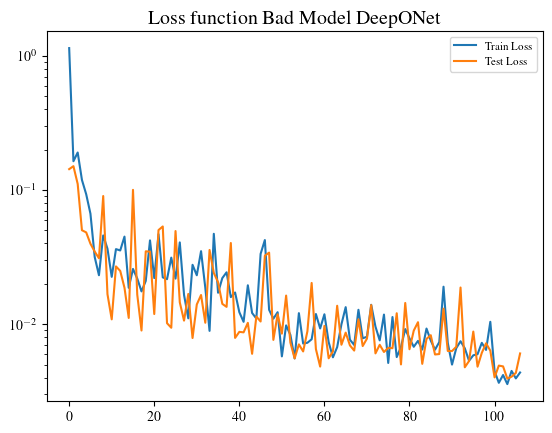

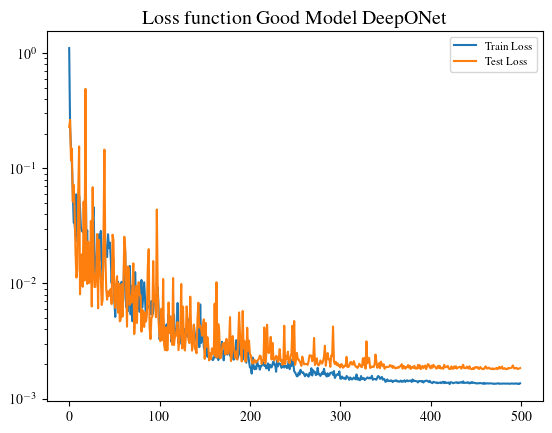

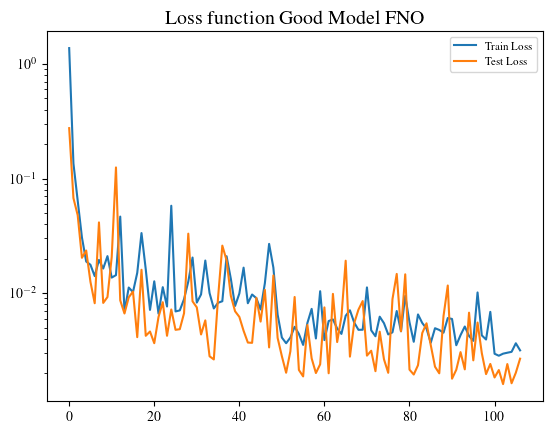

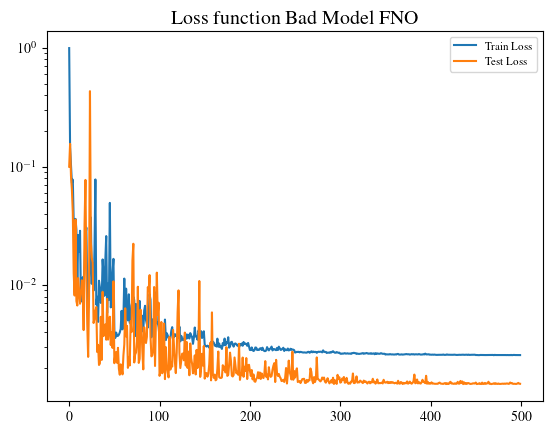

In [17]:
# TRAIN YOUR OWN MODELS IF YOU DON't WANT PRETRAINED.
# dim_x = 1
# m = 400

# # Set Seeds
# torch.manual_seed(2025)
# np.random.seed(2025)

# # Train DeepONet bad model
# modelWorseDeepONet = DeepONetProjected(m, dim_x, 300, 200).cuda()
# modelWorseDeepONet, train_lossArrWorseDeepONet, test_lossArrWorseDeepONet = train_model(modelWorseDeepONet, 107, "DeepONet")
# evaluate_model(modelWorseDeepONet, "Bad Model DeepONet", train_lossArrWorseDeepONet, test_lossArrWorseDeepONet)
# torch.save(modelWorseDeepONet.state_dict(), "models/worseModelDeepONet")

# # Train DeepONET good model
# modelBetterDeepONet = DeepONetProjected(m, dim_x, 300, 200).cuda()
# modelBetterDeepONet, train_lossArrBetterDeepONet, test_lossArrBetterDeepONet = train_model(modelBetterDeepONet, 500, "DeepONet")
# evaluate_model(modelBetterDeepONet, "Good Model DeepONet", train_lossArrBetterDeepONet, test_lossArrBetterDeepONet)
# torch.save(modelBetterDeepONet.state_dict(), "models/betterModelDeepONet")

# # Train FNO bad model
# modelBetterFNO = FNOProjected(m, dim_x, 300, 200, 8, 32).cuda()
# modelBetterFNO, train_lossArrBetterFNO, test_lossArrBetterFNO = train_model(modelBetterFNO, 107, "FNO")
# torch.save(modelBetterFNO.state_dict(), "models/betterModelFNO")
# evaluate_model(modelBetterFNO,"Good Model FNO", train_lossArrBetterFNO, test_lossArrBetterFNO)


# # Train FNO good model
# modelWorseFNO = FNOProjected(m, dim_x, 300, 200, 8, 32).cuda()
# modelWorseFNO, train_lossArrWorseFNO, test_lossArrWorseFNO = train_model(modelWorseFNO, 500, "FNO")
# torch.save(modelWorseFNO.state_dict(), "models/WorseModelFNO")
# evaluate_model(modelWorseFNO,"Bad Model FNO", train_lossArrWorseFNO, test_lossArrWorseFNO)

In [18]:
print("DeepONET params", count_params(modelBetterDeepONet))
print("FNO params", count_params(modelBetterFNO))

DeepONET params 298133
FNO params 221941


In [22]:
# Open loop example
# Simulate at nice resolution for plotting. This can be reduced
dx = 0.01
dt = 0.005
T = 80
init_cond = [0.03, 30]
D = 1
DOver = 4
DUnder = 0.1
D_estimate = 2
gamma = 1000
b = 1
states_open_loop, predictions_open_loop, controls_open_loop, pde_sol_open_loop, delays_open_loop, lyapunovs_open_loop = simulate_system_open_loop(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, compute_predictors, None, True)

In [26]:
t_numerical = np.arange(0, T, dt)

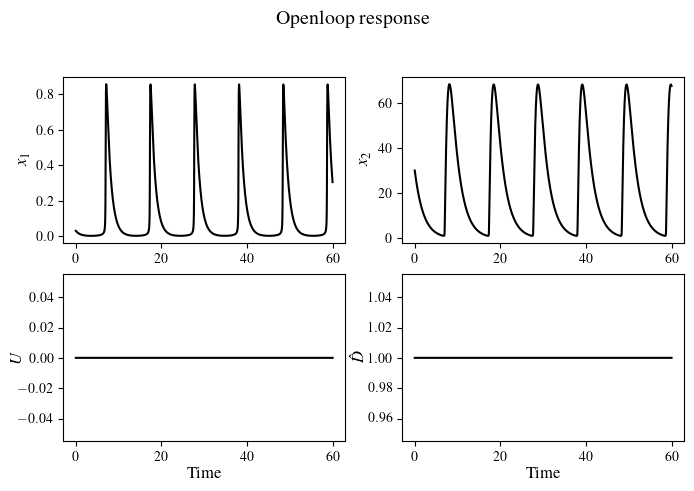

In [27]:
# Make a nice set of plots 
t_end_ML = 12000
t_end_numerical = 12000
res = 1
fig = plt.figure(figsize=set_size(504, 0.99, (2,2), height_add=0.5))
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),#0
     ('dotted',                (0, (1, 5))),#1
     ('densely dotted',        (0, (1, 1))),#2
     ('long dash with offset', (5, (10, 3))),#3
     ('loosely dashed',        (0, (5, 10))),#4
     ('dashed',                (0, (5, 5))),#5
     ('densely dashed',        (0, (5, 1))),#6
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),#7
     ('dashdotted',            (0, (3, 5, 1, 5))),#8
     ('densely dashdotted',    (0, (3, 1, 1, 1))),#9
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),#10
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),#11
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]#12
subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.suptitle("Openloop response")

subfig.subplots_adjust(left=0.08, bottom=0, right=0.98, top=0.7, wspace=0.2, hspace=0.)
axes = subfig.subplots(nrows=1, ncols=2)

line1, =axes[0].plot(t_numerical[0:t_end_numerical], states_open_loop[0:t_end_numerical,0], label="Numerical $\hat{D}(0)=2$", color="black")
axes[0].set_ylabel("$x_1$")
# Add a centered legend above the plot

axes[1].plot(t_numerical[0:t_end_numerical], states_open_loop[0:t_end_numerical,1], label="Numerical $\hat{D}(0)=2$", color="black")
axes[1].set_ylabel("$x_2$", labelpad=5)


subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.08, bottom=0.17, right=0.98, top=0.87, wspace=0.2, hspace=0.)

axes[0].plot(t_numerical[2:t_end_numerical+1], controls_open_loop[1:t_end_numerical], label="Numerical $\hat{D}(0)=2$", color="black")
axes[0].set_ylabel("$U$", labelpad=-5)
axes[0].set_xlabel("Time", labelpad=2)


axes[1].plot(t_numerical[0:t_end_numerical], np.ones(t_end_numerical), label="Numerical $\hat{D}(0)=2$", color="black")
axes[1].set_xlabel("Time", labelpad=2)
axes[1].set_ylabel("$\hat{D}$", labelpad=1)

plt.savefig("openloop.pdf", dpi=300)

In [28]:
def ml_predictor_deeponet(state, controls, D_estimate, x, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back. 
    inputs = np.zeros((len(x), 4))
    inputs[:, 2:4] =  np.vstack((state,)* len(x))
    inputs[:, 0] = np.repeat(D_estimate, len(x))
    inputs[:, 1] = np.copy(controls)
    inputs = inputs.reshape((1, len(x)*4)).astype(np.float32)
    inputs = torch.from_numpy(inputs).cuda()
    output = model((inputs, grid)).detach().cpu().numpy().reshape((len(x), 2))
    return output

def ml_predictor_fno(state, controls, D_estimate, x, model):
    # The conversion time here actually can be expensive to go from CPU to GPU and back. 
    inputs = np.zeros((len(x), 4))
    inputs[:, 2:4] =  np.vstack((state,)* len(x))
    inputs[:, 0] = np.repeat(D_estimate, len(x))
    inputs[:, 1] = np.copy(controls)
    inputs = inputs.reshape((1, len(x)*4)).astype(np.float32)
    inputs = torch.from_numpy(inputs).cuda()
    output = model(inputs).detach().cpu().numpy().reshape((len(x), 2))
    return output

In [33]:
dx = 0.01
dt = 0.005
T = 100
init_cond = [0.03, 30]
D = 1
DOver = 4
DUnder = 0.1
D_estimate = 2
gamma = 1000
b = 1
t_numerical = np.arange(0, T, dt)
states, predictions, controls, pde_sol, delays, lyapunovs = simulate_system(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, compute_predictors, None, True)
states_no_update, predictions_no_update, controls_no_update, pde_sol_no_update, delays_no_update, lyapunovs_no_update = simulate_system(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, compute_predictors, None, False)

In [34]:
dx = 0.01
dt = 0.005
T = 100
init_cond = [0.03, 30]
D = 1
DOver = 4
DUnder = 0.1
gamma = 1000
b = 1
# Better models
D_estimate = 2
t_ml = np.arange(0, T, dt)

# TO USE FNO, replace ml_predictor_deeponet with ml_predictor_fno and change the model in the simulate_system arguments. 
statesML, predictionsML, controlsML, pde_solML, delaysML, lyapunovsML = simulate_system(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, ml_predictor_deeponet, modelBetterDeepONet, True)

# Uncomment to try different delays
#D_estimate = 0.5
#statesML2, predictionsML2, controlsML2, pde_solML2, delaysML2, lyapunovsML2 = simulate_system(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, ml_predictor, modelBetter, True)
# Worse Model
D_estimate = 2
statesML3, predictionsML3, controlsML3, pde_solML3, delaysML3, lyapunovsML3 = simulate_system(dt, T, dx, init_cond, D, D_estimate, DOver, DUnder, gamma, b, ml_predictor_deeponet, modelWorseDeepONet, True)

FINAL STATE [0.09496809 5.39436828]


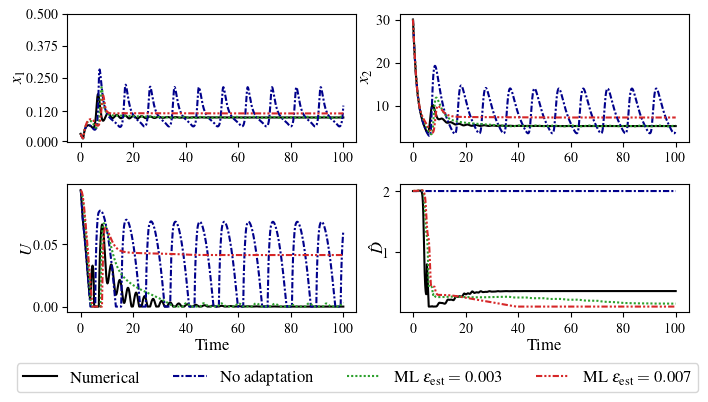

In [61]:
# Make a nice set of plots 
t_end_ML = 19999
t_end_numerical = 19999
res = 1
fig = plt.figure(figsize=set_size(504, 0.99, (2,2), height_add=0))
linestyle_tuple = [
     ('loosely dotted',        (0, (1, 10))),#0
     ('dotted',                (0, (1, 5))),#1
     ('densely dotted',        (0, (1, 1))),#2
     ('long dash with offset', (5, (10, 3))),#3
     ('loosely dashed',        (0, (5, 10))),#4
     ('dashed',                (0, (5, 5))),#5
     ('densely dashed',        (0, (5, 1))),#6
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),#7
     ('dashdotted',            (0, (3, 5, 1, 5))),#8
     ('densely dashdotted',    (0, (3, 1, 1, 1))),#9
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),#10
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),#11
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]#12

subfigs = fig.subfigures(nrows=2, ncols=1, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.08, bottom=0.3, right=0.98, top=0.9, wspace=0.15, hspace=0.)
axes = subfig.subplots(nrows=1, ncols=2)

line1, =axes[0].plot(t_numerical[0:t_end_numerical], states[0:t_end_numerical,0], label="Numerical $\hat{D}(0)=2$", color="black")
line2, =axes[0].plot(t_numerical[0:t_end_numerical], states_no_update[0:t_end_numerical,0], label="Numerical $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
line3, =axes[0].plot(t_ml[0:t_end_ML], statesML[0:t_end_ML,0], label="Machine learning $\epsilon_{est}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
line4, =axes[0].plot(t_ml[0:t_end_ML], statesML3[0:t_end_ML,0], label="Machine learning $\epsilon_{est}=0.007$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
             ,color="#d62728")
axes[0].set_ylabel("$x_1$", labelpad=1)
axes[0].set_yticks([0, 0.12, 0.25, 0.375, 0.5])

axes[1].plot(t_numerical[0:t_end_numerical], states[0:t_end_numerical,1], label="Numerical $\hat{D}(0)=2$", color="black")
axes[1].plot(t_numerical[0:t_end_numerical], states_no_update[0:t_end_numerical,1], label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t_ml[0:t_end_ML], statesML[0:t_end_ML,1], label="Machine learning $\epsilon_{est}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[1].plot(t_ml[0:t_end_ML], statesML3[0:t_end_ML,1], label="Machine learning $\epsilon_{est}=0.007$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
             ,color="#d62728")
axes[1].set_ylabel("$x_2$", labelpad=3)

subfig = subfigs[1]
axes = subfig.subplots(nrows=1, ncols=2)
subfig.subplots_adjust(left=0.08, bottom=0.5, right=0.98, top=1.1, wspace=0.15, hspace=0.)

axes[0].plot(t_numerical[2:t_end_numerical+1], controls[1:t_end_numerical], label="Numerical $\hat{D}(0)=2$", color="black")
axes[0].plot(t_numerical[2:t_end_numerical+1], controls_no_update[1:t_end_numerical], label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[0].plot(t_ml[2:t_end_ML+1], controlsML[1:t_end_ML], label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[0].plot(t_ml[2:t_end_ML+1], controlsML3[1:t_end_ML], label="Machine learning $\epsilon_{\mathregular{est}}=0.007$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
             ,color="#d62728")
axes[0].set_ylabel("$U$", labelpad=-1)
axes[0].set_xlabel("Time", labelpad=2)


axes[1].plot(t_numerical[0:t_end_numerical], delays[1:t_end_numerical+1], label="Numerical $\hat{D}(0)=2$", color="black")
axes[1].plot(t_numerical[0:t_end_numerical], delays_no_update[1:t_end_numerical+1], label="No adaptation $\hat{D}(0)=2$", linestyle=linestyle_tuple[9][1], color="#00008B")
axes[1].plot(t_ml[0:t_end_ML], delaysML[0:t_end_ML], label="Machine learning $\epsilon_{\mathregular{est}}=0.003$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[2][1]\
            ,color="#2ca02c")
axes[1].plot(t_ml[0:t_end_ML], delaysML3[0:t_end_ML], label="Machine learning $\epsilon_{\mathregular{est}}=0.007$, $\hat{D}(0)=2$", linestyle=linestyle_tuple[12][1]\
             ,color="#d62728")
axes[1].set_xlabel("Time", labelpad=2)
axes[1].set_ylabel("$\hat{D}$", labelpad=-2)

# Add a centered legend above the plot
subfig.legend([line1, line2, line3, line4], 
              labels=["Numerical", 
                      "No adaptation", 
                      "ML $\epsilon_{\mathrm{est}}=0.003$", 
                      "ML $\epsilon_{\mathrm{est}}=0.007$"],
              loc='upper center', 
              bbox_to_anchor=(0.5, .3), 
              ncol=4, fontsize=12)

plt.savefig("res.pdf", dpi=300)
print("FINAL STATE", statesML[-1])

In [68]:
# Get speedups
dx = 0.01
x = np.arange(0, 1, dx)
state = [0.01, 30]
modelDeepONet = DeepONetProjected(len(x)*4, 1, len(x)*3, len(x)*2).cuda()
modelFNO = FNOProjected(len(x)*4, 1, len(x)*3, len(x)*2,8,32).cuda()

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)

Numerical time 1.6692166328430176
ML time DeepONet 0.5156779289245605
Speedup DeepONet 3.236936349640068
ML time FNO 1.350022554397583
Speedup FNO 1.2364361079788535


In [69]:
# Get speedups
dx = 0.005
x = np.arange(0, 1, dx)
state = [0.01, 30]
modelDeepONet = DeepONetProjected(len(x)*4, 1, len(x)*3, len(x)*2).cuda()
modelFNO = FNOProjected(len(x)*4, 1, len(x)*3, len(x)*2,8,32).cuda()

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)

Numerical time 3.383406400680542
ML time DeepONet 0.5930755138397217
Speedup DeepONet 5.704849250604714
ML time FNO 1.4423799514770508
Speedup FNO 2.345710918413562


In [70]:
# Get speedups
dx = 0.001
x = np.arange(0, 1, dx)
state = [0.01, 30]
modelDeepONet = DeepONetProjected(len(x)*4, 1, len(x)*3, len(x)*2).cuda()
modelFNO = FNOProjected(len(x)*4, 1, len(x)*3, len(x)*2,8,32).cuda()

spatial = np.arange(0, 1, dx/4.0).astype(np.float32)
grid=torch.from_numpy(spatial.reshape((len(spatial), 1))).cuda()
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    compute_predictors(state, x, delay, x, None)
end = time.time()
numerical_time = end-start
print("Numerical time", numerical_time)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_deeponet(state, x, delay, x, modelDeepONet)
end = time.time()
ml_time_deeponet = end-start
print("ML time DeepONet", ml_time_deeponet)
print("Speedup DeepONet", numerical_time/ml_time_deeponet)
start = time.time()
for i in range(1000):
    delay = np.random.uniform(0.5, 1.7)
    ml_predictor_fno(state, x, delay, x, modelFNO)
end = time.time()
ml_time_fno = end-start
print("ML time FNO", ml_time_fno)
print("Speedup FNO", numerical_time/ml_time_fno)

Numerical time 18.986052989959717
ML time DeepONet 1.311234712600708
Speedup DeepONet 14.479522855448744
ML time FNO 2.2400898933410645
Speedup FNO 8.475576380393498
